In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import f
from scipy import stats 
!pip install pyupbit
import pyupbit as pu
from typing import List

## 1 데이터 불러오기 

### 다변량 정규분포를 갖는 데이터

In [2]:
cov = np.array([[6,3,2,4,-3],
                [3,1,4.2,-3,2.2],
                [1,3.2,-3,2,1],
                [3,-3,1,2,1],
                [-3, 3.5,1,2,3]])
rng = np.random.default_rng()
mvnX = rng.multivariate_normal([0,0,0,0,0], cov, size=200)

print(mvnX.shape)


(200, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


### 다변량 정규분포를 갖지 않는 데이터

In [3]:
bitcoin = pu.get_ohlcv("KRW-BTC")["close"]
ether = pu.get_ohlcv("KRW-ETH")["close"]
axs = pu.get_ohlcv("KRW-AXS")["close"]
wave = pu.get_ohlcv("KRW-WAVES")["close"]
ethereum_classic = pu.get_ohlcv("KRW-ETC")["close"]

mv_data = pd.concat([bitcoin,ether,axs,wave,ethereum_classic],axis=1)
mv_data.columns = ["bitcoin","ether","axs","wave","ethereum_classic"]
non_mvn_X = mv_data 
non_mvn_X.head(3)

,bitcoin,ether,axs,wave,ethereum_classic
2021-09-15 09:00:00,57207000.0,4291000.0,81490.0,36200.0,70280.0
2021-09-16 09:00:00,57277000.0,4278000.0,80650.0,37120.0,69590.0
2021-09-17 09:00:00,57642000.0,4150000.0,80230.0,35180.0,69020.0


#### numpy로 변환

In [4]:
non_mvn_X  = non_mvn_X .to_numpy()

### 정규성 검정

In [5]:

# 다변량 정규분포 갖는 데이터 검정
result1 = stats.shapiro(mvnX)

# 다변량 정규분포를 갖지 않는 데이터 검정

result2 = stats.shapiro(non_mvn_X)

print("다변량 정규 분포를 갖는 데이터의 샤피로 검정 결과 pvalue: ",result1[1])
print("다변량 정규 분포를 갖지 않는 데이터의 샤피로 검정 결과 pvalue: ",result2[1])

다변량 정규 분포를 갖는 데이터의 샤피로 검정 결과 pvalue:  0.7029556632041931
다변량 정규 분포를 갖지 않는 데이터의 샤피로 검정 결과 pvalue:  5.605193857299268e-44


## 2 MultiVariate T^2 Control Charts

In [28]:
def calculate_t_square_control_chart(data:np.array, alpha: float = None)->List[np.array]:
    
    array_data = np.array(data)
    
    m = len(data)
    p = array_data.shape[1]
    
    col_mean = np.mean(array_data, axis=0)  
    mat_cov = np.cov(array_data.T)  
    mat_inv_s = np.linalg.inv(mat_cov)  
    
    values = []
    for sample in array_data:
        dif = sample - col_mean
        value = mat_inv_s.dot(dif.T).dot(dif)  
        values.append(value)
    
    CL = (np.power((m -1), 2)) / m
    LCL = 0
    UCL = CL * beta.ppf((1-alpha), p/2, (m - p - 1)/2)
            
    return values, LCL, UCL

### 관리도 그리기 함수

In [29]:
def plot_control_chart(X: np.array)-> None:
  alphas = [0.01,0.05,0.1]

  for alpha in alphas:
      values, LCL, UCL = calculate_t_square_control_chart(X, alpha=alpha)
      
      plt.plot(values, marker='o', color='r')
      plt.axhline(UCL, color='r', label='UCL', linestyle='--')
      # plt.axhline(center, color='black', label='Center')
      plt.axhline(LCL, color='b', label='LCL', linestyle='--')
      plt.legend()
      plt.title(f'T-square Control Chart, alpha = {np.round(alpha,3)}')
      plt.xlabel('Observation')
      plt.show()

# 3. 비교 평가

## 다변량 정규 분포 데이터로 T2 차트 그리기

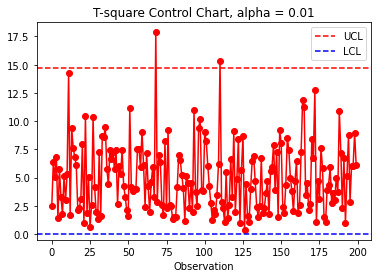

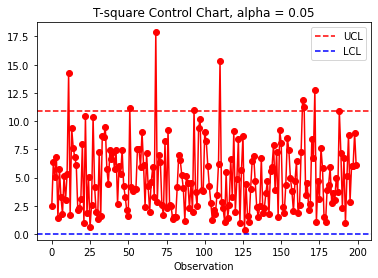

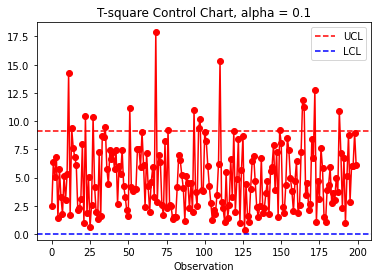

In [30]:
plot_control_chart(mvnX)

## 다변량 정규 분포를 갖지 않는 데이터로 T2 차트 그리기

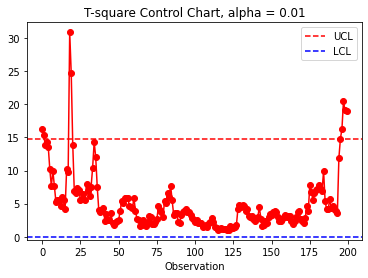

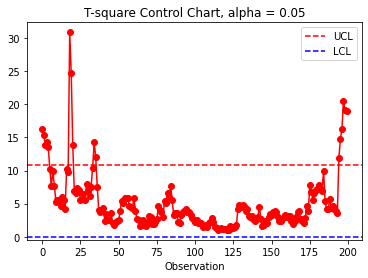

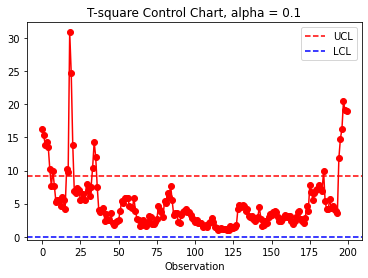

In [26]:
plot_control_chart(non_mvn_X)